<a href="https://colab.research.google.com/github/efrat-dev/insider-threat-detector/blob/main/full_pipline_claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating 50,000 records...
Calculated parameters: 277 employees over 180 days
Generating dataset with 277 employees over 180 days...
Malicious employees: 19 (7.0%)
Dataset generated: 49860 records
Final dataset size: 49,860 records
=== EXPLORATORY DATA ANALYSIS ===

Dataset Info:
Shape: (49860, 43)
Malicious employees: 3420 (6.9%)
Date range: 2024-12-11 to 2025-06-08
Unique employees: 277

Missing Values:
country_name             48845
trip_day_number          48845
burn_location_campus     47032
print_location_campus    32799
first_entry_time          2570
last_exit_time            2570
dtype: int64


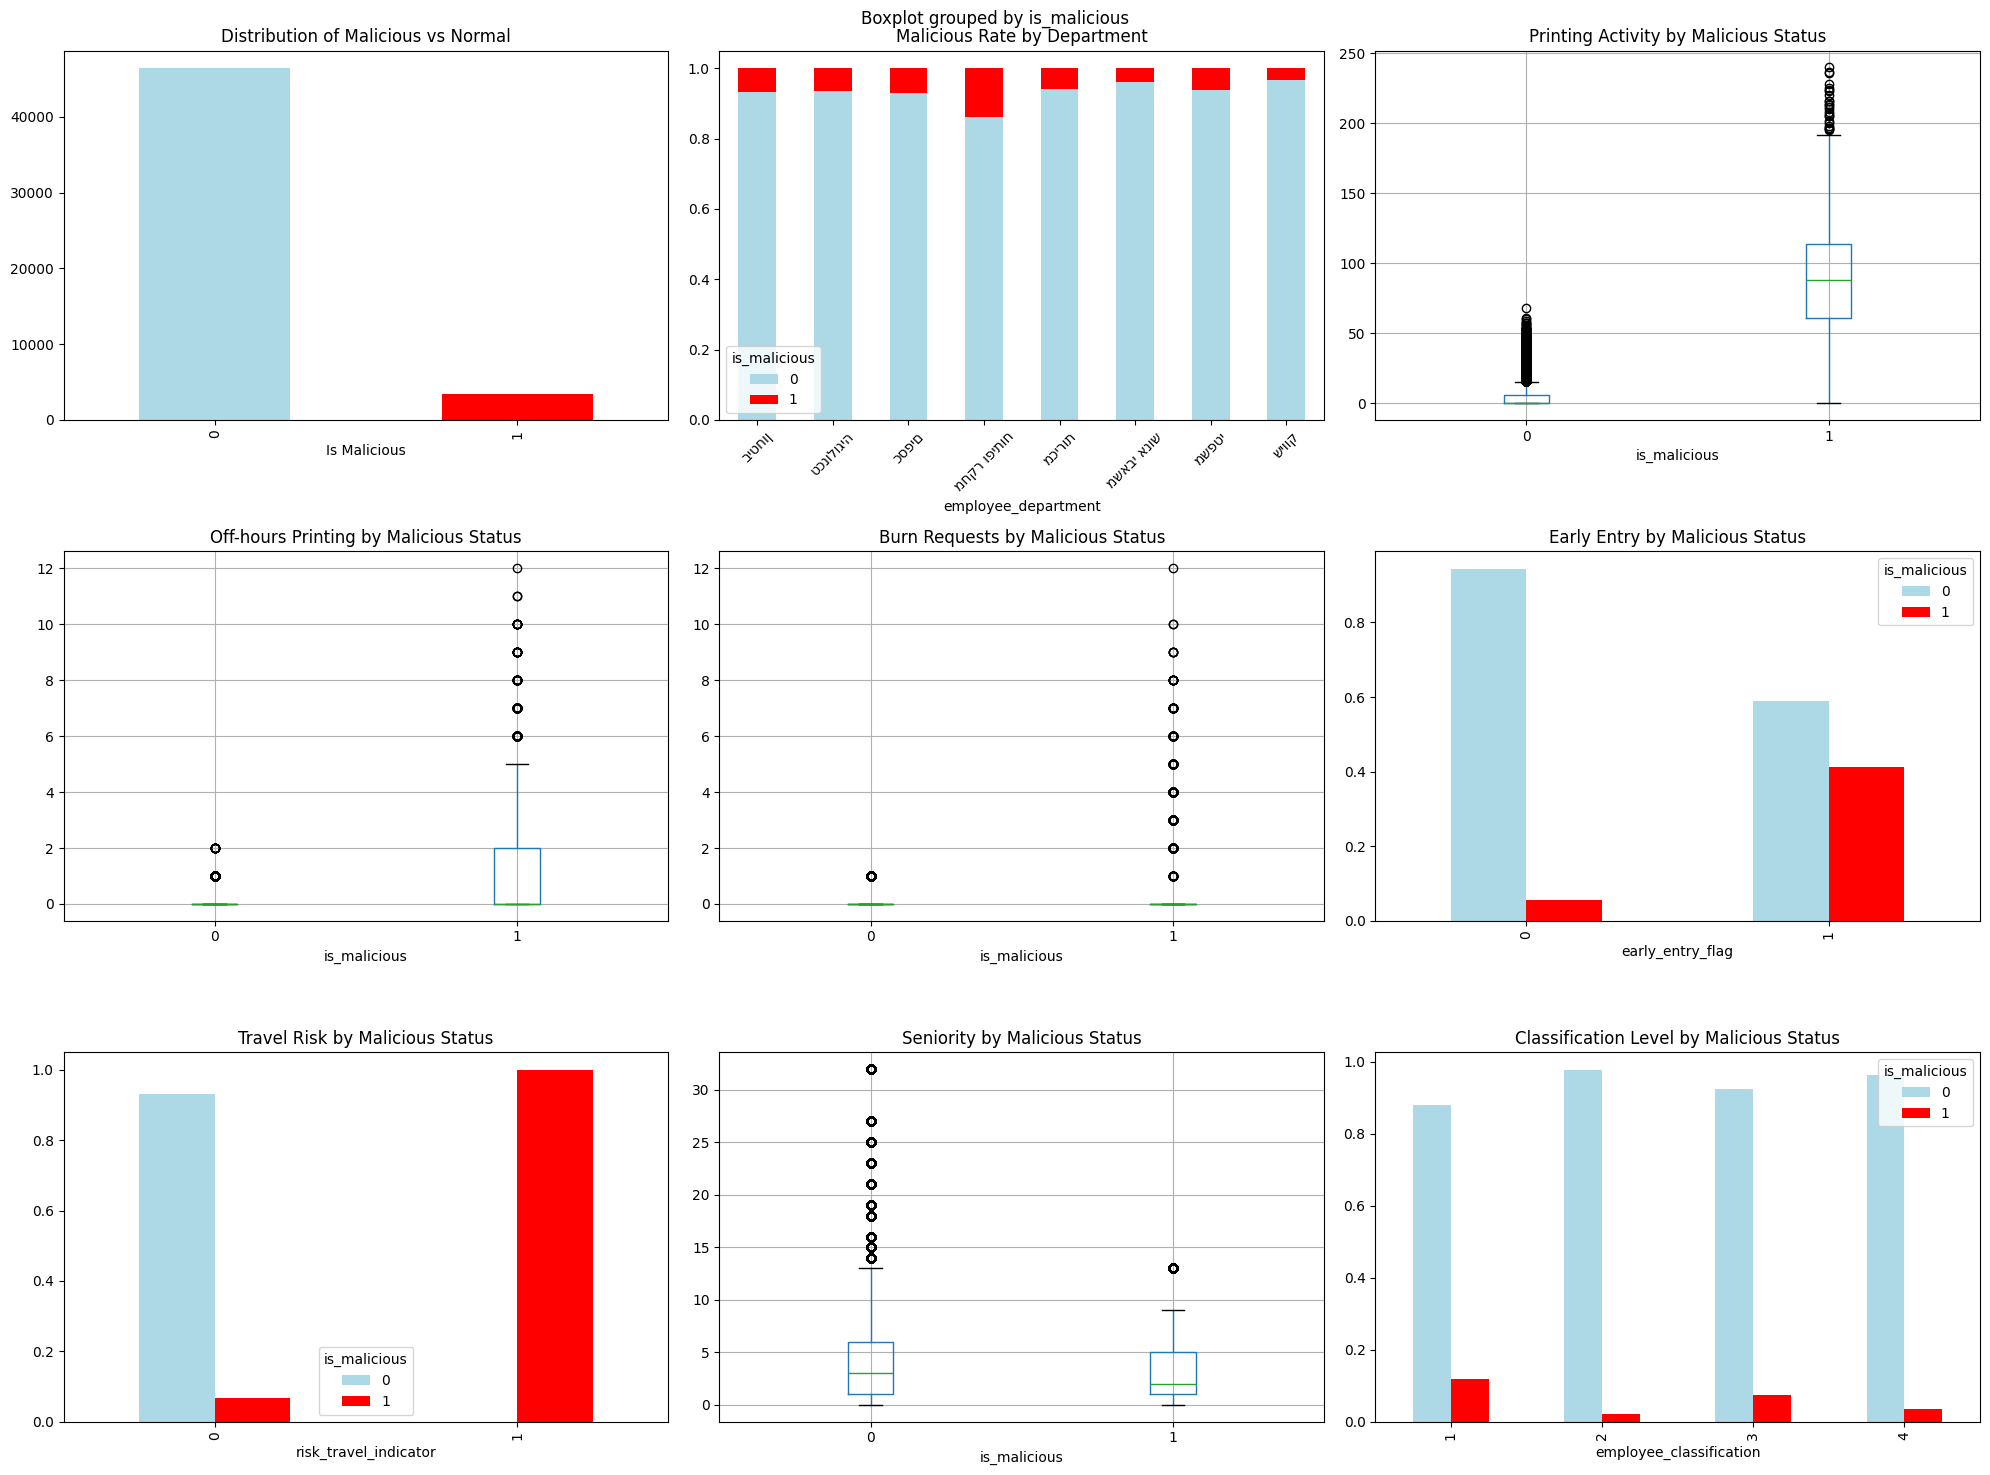


=== CORRELATION ANALYSIS ===


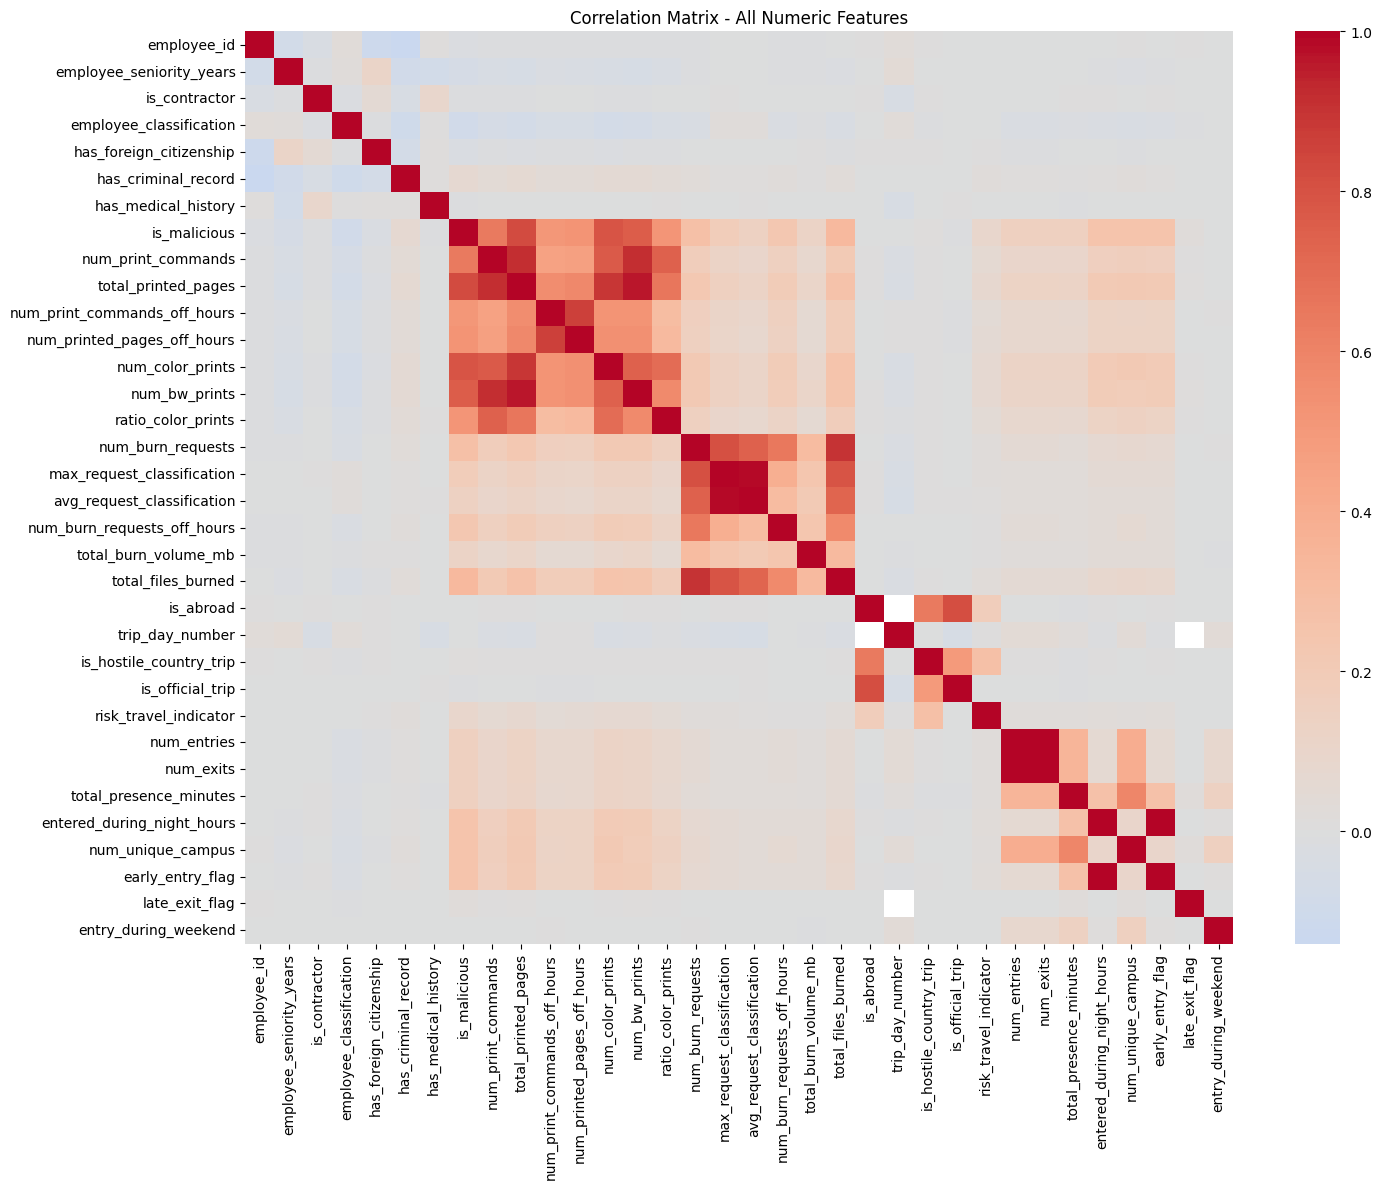


Features most correlated with malicious behavior:
is_malicious                    1.000000
total_printed_pages             0.823245
num_color_prints                0.789713
num_bw_prints                   0.762201
num_print_commands              0.646948
num_printed_pages_off_hours     0.523787
ratio_color_prints              0.516219
num_print_commands_off_hours    0.507795
total_files_burned              0.325519
num_burn_requests               0.278291
num_unique_campus               0.257134
entered_during_night_hours      0.254257
early_entry_flag                0.254257
num_burn_requests_off_hours     0.230033
max_request_classification      0.181905
Name: is_malicious, dtype: float64

=== FEATURE PREPARATION ===
Features prepared: 42 features
Feature importance will be calculated during model training

=== MODEL TRAINING ===

Training Random Forest...
Random Forest - AUC Score: 0.9998
Classification Report:
              precision    recall  f1-score   support

           0    

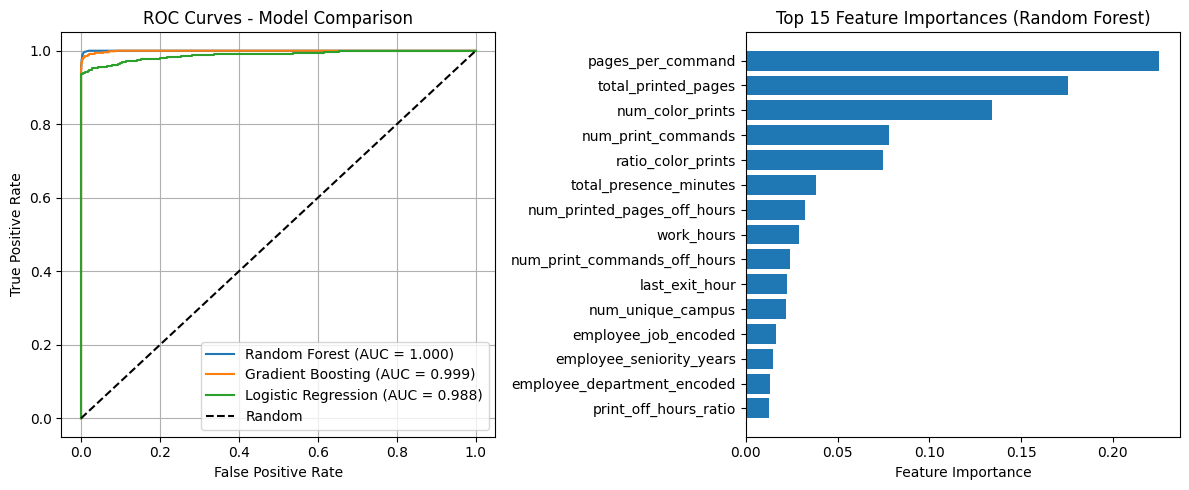

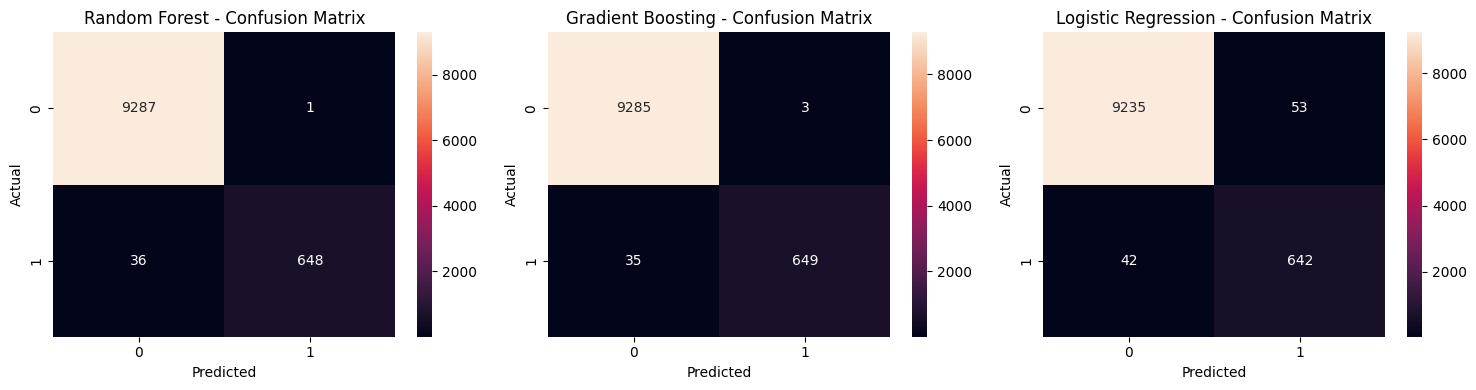


=== MALICIOUS BEHAVIOR ANALYSIS ===
Best performing model: Random Forest

High-risk samples identified: 638
Characteristics of high-risk behavior:

Department distribution:
employee_department
מחקר ופיתוח    157
כספים          102
מכירות          95
ביטחון          71
משפטי           70
טכנולוגיה       64
שיווק           41
משאבי אנוש      38
Name: count, dtype: int64

Average metrics for high-risk samples:
total_printed_pages: 91.14
num_print_commands_off_hours: 1.30
num_burn_requests: 0.62
total_burn_volume_mb: 1435.29
num_unique_campus: 1.26
early_entry_flag: 0.19
late_exit_flag: 0.00

Top 10 riskiest employees (by model prediction):
 employee_id  is_malicious  prediction_proba
          81             1          0.993103
          89             1          0.969706
         218             1          0.967222
         262             1          0.961765
         114             1          0.954000
          66             1          0.952105
         181             1          0.9

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class InsiderThreatDataGenerator:
    def __init__(self, num_employees=1000, days_range=180, malicious_ratio=0.07):
        self.num_employees = num_employees
        self.days_range = days_range
        self.malicious_ratio = malicious_ratio
        self.malicious_employees = int(num_employees * malicious_ratio)

        # Define realistic distributions and parameters
        self.departments = ['טכנולוגיה', 'כספים', 'משאבי אנוש', 'מכירות', 'מחקר ופיתוח', 'ביטחון', 'משפטי', 'שיווק']
        self.campuses = ['A', 'B', 'C']
        self.jobs = ['מנהל', 'אנליסט', 'מפתח', 'רואה חשבון', 'יועץ', 'חוקר', 'מתכנת', 'מנהל פרויקט']
        self.countries = ['ארה"ב', 'גרמניה', 'צרפת', 'בריטניה', 'איטליה', 'יפן', 'איראן', 'סוריה', 'לבנון', 'קוריאה הצפונית']
        self.hostile_countries = ['איראן', 'סוריה', 'לבנון', 'קוריאה הצפונית']

        # Generate employee profiles
        self.employees = self._generate_employee_profiles()
        self.malicious_employee_ids = random.sample(list(self.employees.keys()), self.malicious_employees)

    def _generate_employee_profiles(self):
        """Generate realistic employee profiles"""
        employees = {}
        for emp_id in range(1, self.num_employees + 1):
            employees[emp_id] = {
                'department': np.random.choice(self.departments),
                'campus': np.random.choice(self.campuses),
                'job': np.random.choice(self.jobs),
                'seniority_years': max(0, int(np.random.exponential(5))),
                'is_contractor': np.random.choice([0, 1], p=[0.8, 0.2]),
                'classification': np.random.choice([1, 2, 3, 4], p=[0.4, 0.3, 0.2, 0.1]),
                'foreign_citizenship': np.random.choice([0, 1], p=[0.85, 0.15]),
                'criminal_record': np.random.choice([0, 1], p=[0.95, 0.05]),
                'medical_history': np.random.choice([0, 1], p=[0.85, 0.15])
            }
        return employees

    def _is_off_hours(self, dt):
        """Check if datetime is during off hours"""
        if dt.weekday() == 4 and dt.hour >= 16:  # Friday after 16:00
            return True
        if dt.weekday() == 5:  # Saturday
            return True
        if dt.time() < datetime.strptime("05:00", "%H:%M").time() or dt.time() > datetime.strptime("21:00", "%H:%M").time():
            return True
        return False

    def _is_weekend(self, dt):
        """Check if datetime is weekend"""
        return dt.weekday() >= 4  # Friday or Saturday

    def _generate_print_activity(self, emp_id, date, is_malicious):
        """Generate realistic printing activity"""
        base_date = datetime.combine(date, datetime.min.time())

        # Normal employees print less
        if not is_malicious:
            if np.random.random() < 0.7:  # 70% chance of no printing
                return {
                    'print_location_campus': None,
                    'num_print_commands': 0,
                    'total_printed_pages': 0,
                    'num_print_commands_off_hours': 0,
                    'num_printed_pages_off_hours': 0,
                    'num_color_prints': 0,
                    'num_bw_prints': 0,
                    'ratio_color_prints': 0
                }

            # Normal printing patterns
            num_commands = np.random.poisson(3)
            total_pages = sum(np.random.poisson(5) for _ in range(num_commands))
            color_ratio = np.random.beta(2, 8)  # Most prints are B&W

        else:
            # Malicious employees might print more, especially off-hours
            if np.random.random() < 0.9:  # Malicious employees print more often
                num_commands = np.random.poisson(8)
                total_pages = sum(np.random.poisson(12) for _ in range(num_commands))
                color_ratio = np.random.beta(3, 5)  # More color prints (documents, charts)
            else:
                return {
                    'print_location_campus': None,
                    'num_print_commands': 0,
                    'total_printed_pages': 0,
                    'num_print_commands_off_hours': 0,
                    'num_printed_pages_off_hours': 0,
                    'num_color_prints': 0,
                    'num_bw_prints': 0,
                    'ratio_color_prints': 0
                }

        # Determine if printing in different campus (suspicious)
        employee_campus = self.employees[emp_id]['campus']
        if is_malicious and np.random.random() < 0.3:
            print_campus = np.random.choice([c for c in self.campuses if c != employee_campus])
        else:
            print_campus = employee_campus if np.random.random() < 0.9 else np.random.choice(self.campuses)

        # Calculate off-hours printing
        off_hours_commands = 0
        off_hours_pages = 0

        if is_malicious and np.random.random() < 0.4:  # Malicious more likely to print off-hours
            off_hours_commands = max(0, int(num_commands * np.random.uniform(0.2, 0.8)))
            off_hours_pages = max(0, int(total_pages * np.random.uniform(0.2, 0.8)))
        elif np.random.random() < 0.1:  # Normal employees occasionally print off-hours
            off_hours_commands = max(0, int(num_commands * np.random.uniform(0.1, 0.3)))
            off_hours_pages = max(0, int(total_pages * np.random.uniform(0.1, 0.3)))

        num_color = int(total_pages * color_ratio)
        num_bw = total_pages - num_color

        return {
            'print_location_campus': print_campus,
            'num_print_commands': num_commands,
            'total_printed_pages': total_pages,
            'num_print_commands_off_hours': off_hours_commands,
            'num_printed_pages_off_hours': off_hours_pages,
            'num_color_prints': num_color,
            'num_bw_prints': num_bw,
            'ratio_color_prints': color_ratio if total_pages > 0 else 0
        }

    def _generate_burn_activity(self, emp_id, date, is_malicious):
        """Generate CD/USB burning activity"""
        # Most days have no burning activity
        if not is_malicious and np.random.random() < 0.95:
            return {
                'burn_location_campus': None,
                'num_burn_requests': 0,
                'max_request_classification': 0,
                'avg_request_classification': 0,
                'num_burn_requests_off_hours': 0,
                'total_burn_volume_mb': 0,
                'total_files_burned': 0
            }

        if is_malicious and np.random.random() < 0.85:
            return {
                'burn_location_campus': None,
                'num_burn_requests': 0,
                'max_request_classification': 0,
                'avg_request_classification': 0,
                'num_burn_requests_off_hours': 0,
                'total_burn_volume_mb': 0,
                'total_files_burned': 0
            }

        employee_campus = self.employees[emp_id]['campus']
        employee_classification = self.employees[emp_id]['classification']

        if is_malicious:
            num_requests = np.random.poisson(3) + 1
            # Malicious users try to access higher classification data
            max_classification = min(4, employee_classification + np.random.choice([0, 1, 2], p=[0.3, 0.4, 0.3]))
            classifications = [np.random.randint(1, max_classification + 1) for _ in range(num_requests)]
            burn_campus = np.random.choice(self.campuses)  # May burn from different campus
            volume_mb = np.random.lognormal(8, 1.5)  # Larger volumes
            num_files = np.random.poisson(50) + 10
        else:
            num_requests = 1
            max_classification = min(employee_classification, np.random.choice([1, 2, 3], p=[0.6, 0.3, 0.1]))
            classifications = [max_classification]
            burn_campus = employee_campus
            volume_mb = np.random.lognormal(6, 1)  # Smaller volumes
            num_files = np.random.poisson(10) + 1

        # Off-hours burning (more suspicious)
        off_hours_requests = 0
        if is_malicious and np.random.random() < 0.6:
            off_hours_requests = max(0, int(num_requests * np.random.uniform(0.3, 0.8)))
        elif np.random.random() < 0.05:
            off_hours_requests = max(0, int(num_requests * 0.2))

        return {
            'burn_location_campus': burn_campus,
            'num_burn_requests': num_requests,
            'max_request_classification': max(classifications),
            'avg_request_classification': np.mean(classifications),
            'num_burn_requests_off_hours': off_hours_requests,
            'total_burn_volume_mb': int(volume_mb),
            'total_files_burned': num_files
        }

    def _generate_travel_activity(self, emp_id, date, is_malicious):
        """Generate travel activity"""
        # Most days - no travel
        if np.random.random() < 0.98:
            return {
                'is_abroad': 0,
                'trip_day_number': None,
                'country_name': None,
                'is_hostile_country_trip': 0,
                'is_official_trip': 0,
                'risk_travel_indicator': 0
            }

        # Generate travel
        country = np.random.choice(self.countries)
        is_hostile = 1 if country in self.hostile_countries else 0
        is_official = np.random.choice([0, 1], p=[0.3, 0.7])  # Most business trips are official

        # Malicious employees more likely to travel to hostile countries privately
        if is_malicious and np.random.random() < 0.4:
            country = np.random.choice(self.hostile_countries)
            is_hostile = 1
            is_official = 0

        trip_day = np.random.randint(1, 15)  # Trip duration 1-14 days

        # Risk indicator calculation
        risk_indicator = 0
        if is_hostile and not is_official and is_malicious:
            risk_indicator = 1

        return {
            'is_abroad': 1,
            'trip_day_number': trip_day,
            'country_name': country,
            'is_hostile_country_trip': is_hostile,
            'is_official_trip': is_official,
            'risk_travel_indicator': risk_indicator
        }

    def _generate_access_activity(self, emp_id, date, is_malicious):
        """Generate building access activity"""
        if np.random.random() < 0.05:  # 5% chance of no access (sick day, vacation)
            return {
                'num_entries': 0,
                'num_exits': 0,
                'first_entry_time': None,
                'last_exit_time': None,
                'total_presence_minutes': 0,
                'entered_during_night_hours': 0,
                'num_unique_campus': 0,
                'early_entry_flag': 0,
                'late_exit_flag': 0,
                'entry_during_weekend': 0
            }

        base_date = datetime.combine(date, datetime.min.time())

        # Normal work patterns
        if not is_malicious:
            num_entries = np.random.choice([1, 2, 3], p=[0.7, 0.25, 0.05])
            first_entry = base_date + timedelta(hours=np.random.normal(8, 1))  # Around 8 AM
            last_exit = base_date + timedelta(hours=np.random.normal(17, 1.5))  # Around 5 PM
        else:
            # Malicious employees might have irregular hours
            num_entries = np.random.choice([1, 2, 3, 4], p=[0.5, 0.3, 0.15, 0.05])
            if np.random.random() < 0.3:  # Sometimes very early or very late
                first_entry = base_date + timedelta(hours=np.random.uniform(5, 7))
                last_exit = base_date + timedelta(hours=np.random.uniform(19, 23))
            else:
                first_entry = base_date + timedelta(hours=np.random.normal(8, 1.5))
                last_exit = base_date + timedelta(hours=np.random.normal(17, 2))

        # Ensure logical order
        if last_exit <= first_entry:
            last_exit = first_entry + timedelta(hours=np.random.uniform(4, 10))

        num_exits = num_entries  # Assume balanced entries/exits

        # Calculate presence time
        total_minutes = int((last_exit - first_entry).total_seconds() / 60)

        # Flags
        early_entry = 1 if first_entry.hour < 6 else 0
        late_exit = 1 if last_exit.hour > 22 else 0
        night_entry = 1 if (first_entry.hour >= 22 or first_entry.hour <= 5) else 0
        weekend_entry = 1 if self._is_weekend(first_entry) else 0

        # Multiple campus access (suspicious for malicious)
        employee_campus = self.employees[emp_id]['campus']
        if is_malicious and np.random.random() < 0.2:
            num_unique_campus = np.random.choice([2, 3])
        else:
            num_unique_campus = 1

        return {
            'num_entries': num_entries,
            'num_exits': num_exits,
            'first_entry_time': first_entry.strftime('%H:%M'),
            'last_exit_time': last_exit.strftime('%H:%M'),
            'total_presence_minutes': total_minutes,
            'entered_during_night_hours': night_entry,
            'num_unique_campus': num_unique_campus,
            'early_entry_flag': early_entry,
            'late_exit_flag': late_exit,
            'entry_during_weekend': weekend_entry
        }

    def generate_dataset(self):
        """Generate the complete dataset"""
        print(f"Generating dataset with {self.num_employees} employees over {self.days_range} days...")
        print(f"Malicious employees: {self.malicious_employees} ({self.malicious_ratio:.1%})")

        data = []
        start_date = datetime.now() - timedelta(days=self.days_range)

        for emp_id in range(1, self.num_employees + 1):
            is_malicious = emp_id in self.malicious_employee_ids

            for day in range(self.days_range):
                current_date = start_date + timedelta(days=day)

                # Employee static info
                emp_info = self.employees[emp_id]

                # Generate daily activities
                print_activity = self._generate_print_activity(emp_id, current_date.date(), is_malicious)
                burn_activity = self._generate_burn_activity(emp_id, current_date.date(), is_malicious)
                travel_activity = self._generate_travel_activity(emp_id, current_date.date(), is_malicious)
                access_activity = self._generate_access_activity(emp_id, current_date.date(), is_malicious)

                # Combine all data
                row = {
                    'employee_id': emp_id,
                    'date': current_date.date(),
                    'employee_department': emp_info['department'],
                    'employee_campus': emp_info['campus'],
                    'employee_job': emp_info['job'],
                    'employee_seniority_years': emp_info['seniority_years'],
                    'is_contractor': emp_info['is_contractor'],
                    'employee_classification': emp_info['classification'],
                    'has_foreign_citizenship': emp_info['foreign_citizenship'],
                    'has_criminal_record': emp_info['criminal_record'],
                    'has_medical_history': emp_info['medical_history'],
                    'is_malicious': 1 if is_malicious else 0  # Target variable
                }

                # Add all activity data
                row.update(print_activity)
                row.update(burn_activity)
                row.update(travel_activity)
                row.update(access_activity)

                data.append(row)

        df = pd.DataFrame(data)
        print(f"Dataset generated: {len(df)} records")
        return df

def perform_eda(df):
    """Comprehensive Exploratory Data Analysis"""
    print("=== EXPLORATORY DATA ANALYSIS ===\n")

    # Basic info
    print("Dataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Malicious employees: {df['is_malicious'].sum()} ({df['is_malicious'].mean():.1%})")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique employees: {df['employee_id'].nunique()}")

    # Missing values
    print("\nMissing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0].sort_values(ascending=False))

    # Create visualizations
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Insider Threat Detection - Exploratory Data Analysis', fontsize=16)

    # 1. Distribution of malicious vs normal
    df['is_malicious'].value_counts().plot(kind='bar', ax=axes[0,0], color=['lightblue', 'red'])
    axes[0,0].set_title('Distribution of Malicious vs Normal')
    axes[0,0].set_xlabel('Is Malicious')

    # 2. Department distribution by malicious
    dept_malicious = pd.crosstab(df['employee_department'], df['is_malicious'], normalize='index')
    dept_malicious.plot(kind='bar', ax=axes[0,1], stacked=True, color=['lightblue', 'red'])
    axes[0,1].set_title('Malicious Rate by Department')
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. Printing activity
    df.boxplot(column='total_printed_pages', by='is_malicious', ax=axes[0,2])
    axes[0,2].set_title('Printing Activity by Malicious Status')

    # 4. Off-hours activity
    df.boxplot(column='num_print_commands_off_hours', by='is_malicious', ax=axes[1,0])
    axes[1,0].set_title('Off-hours Printing by Malicious Status')

    # 5. Burn requests
    df.boxplot(column='num_burn_requests', by='is_malicious', ax=axes[1,1])
    axes[1,1].set_title('Burn Requests by Malicious Status')

    # 6. Access patterns - early entry
    early_entry = pd.crosstab(df['early_entry_flag'], df['is_malicious'], normalize='index')
    early_entry.plot(kind='bar', ax=axes[1,2], color=['lightblue', 'red'])
    axes[1,2].set_title('Early Entry by Malicious Status')

    # 7. Travel risk
    travel_risk = pd.crosstab(df['risk_travel_indicator'], df['is_malicious'], normalize='index')
    travel_risk.plot(kind='bar', ax=axes[2,0], color=['lightblue', 'red'])
    axes[2,0].set_title('Travel Risk by Malicious Status')

    # 8. Seniority distribution
    df.boxplot(column='employee_seniority_years', by='is_malicious', ax=axes[2,1])
    axes[2,1].set_title('Seniority by Malicious Status')

    # 9. Classification level
    classification_mal = pd.crosstab(df['employee_classification'], df['is_malicious'], normalize='index')
    classification_mal.plot(kind='bar', ax=axes[2,2], color=['lightblue', 'red'])
    axes[2,2].set_title('Classification Level by Malicious Status')

    plt.tight_layout()
    plt.show()

    # Correlation analysis
    print("\n=== CORRELATION ANALYSIS ===")

    # Select numeric columns for correlation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix - All Numeric Features')
    plt.tight_layout()
    plt.show()

    # Features most correlated with malicious behavior
    malicious_corr = correlation_matrix['is_malicious'].abs().sort_values(ascending=False)
    print("\nFeatures most correlated with malicious behavior:")
    print(malicious_corr.head(15))

    return df

def prepare_features(df):
    """Prepare features for machine learning"""
    print("\n=== FEATURE PREPARATION ===")

    # Create a copy for ML
    ml_df = df.copy()

    # Encode categorical variables
    le_dept = LabelEncoder()
    le_campus = LabelEncoder()
    le_job = LabelEncoder()

    ml_df['employee_department_encoded'] = le_dept.fit_transform(ml_df['employee_department'].fillna('Unknown'))
    ml_df['employee_campus_encoded'] = le_campus.fit_transform(ml_df['employee_campus'].fillna('Unknown'))
    ml_df['employee_job_encoded'] = le_job.fit_transform(ml_df['employee_job'].fillna('Unknown'))

    # Handle print/burn campus encoding
    ml_df['print_location_campus'] = ml_df['print_location_campus'].fillna('None')
    ml_df['burn_location_campus'] = ml_df['burn_location_campus'].fillna('None')

    le_print_campus = LabelEncoder()
    le_burn_campus = LabelEncoder()
    ml_df['print_location_campus_encoded'] = le_print_campus.fit_transform(ml_df['print_location_campus'])
    ml_df['burn_location_campus_encoded'] = le_burn_campus.fit_transform(ml_df['burn_location_campus'])

    # Convert time features
    ml_df['first_entry_time'] = ml_df['first_entry_time'].fillna('08:00')
    ml_df['last_exit_time'] = ml_df['last_exit_time'].fillna('17:00')

    ml_df['first_entry_hour'] = ml_df['first_entry_time'].apply(lambda x: int(str(x).split(':')[0]) if pd.notna(x) else 8)
    ml_df['last_exit_hour'] = ml_df['last_exit_time'].apply(lambda x: int(str(x).split(':')[0]) if pd.notna(x) else 17)

    # Create engineered features
    ml_df['print_off_hours_ratio'] = ml_df['num_print_commands_off_hours'] / (ml_df['num_print_commands'] + 1)
    ml_df['burn_off_hours_ratio'] = ml_df['num_burn_requests_off_hours'] / (ml_df['num_burn_requests'] + 1)
    ml_df['pages_per_command'] = ml_df['total_printed_pages'] / (ml_df['num_print_commands'] + 1)
    ml_df['files_per_mb'] = ml_df['total_files_burned'] / (ml_df['total_burn_volume_mb'] + 1)
    ml_df['work_hours'] = ml_df['last_exit_hour'] - ml_df['first_entry_hour']

    # Campus mismatch features
    ml_df['print_campus_mismatch'] = (ml_df['employee_campus_encoded'] != ml_df['print_location_campus_encoded']).astype(int)
    ml_df['burn_campus_mismatch'] = (ml_df['employee_campus_encoded'] != ml_df['burn_location_campus_encoded']).astype(int)

    # Fill NaN values
    ml_df = ml_df.fillna(0)

    # Select features for ML
    feature_columns = [
        # Employee characteristics
        'employee_department_encoded', 'employee_campus_encoded', 'employee_job_encoded',
        'employee_seniority_years', 'is_contractor', 'employee_classification',
        'has_foreign_citizenship', 'has_criminal_record', 'has_medical_history',

        # Print activity
        'num_print_commands', 'total_printed_pages', 'num_print_commands_off_hours',
        'num_printed_pages_off_hours', 'num_color_prints', 'ratio_color_prints',
        'print_campus_mismatch',

        # Burn activity
        'num_burn_requests', 'max_request_classification', 'avg_request_classification',
        'num_burn_requests_off_hours', 'total_burn_volume_mb', 'total_files_burned',
        'burn_campus_mismatch',

        # Travel
        'is_abroad', 'is_hostile_country_trip', 'is_official_trip', 'risk_travel_indicator',

        # Access
        'num_entries', 'num_exits', 'total_presence_minutes', 'entered_during_night_hours',
        'num_unique_campus', 'early_entry_flag', 'late_exit_flag', 'entry_during_weekend',
        'first_entry_hour', 'last_exit_hour',

        # Engineered features
        'print_off_hours_ratio', 'burn_off_hours_ratio', 'pages_per_command',
        'files_per_mb', 'work_hours'
    ]

    X = ml_df[feature_columns]
    y = ml_df['is_malicious']

    print(f"Features prepared: {len(feature_columns)} features")
    print("Feature importance will be calculated during model training")

    return X, y, feature_columns

def train_models(X, y, feature_columns):
    """Train multiple ML models and compare performance"""
    print("\n=== MODEL TRAINING ===")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)

        # Store results
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'auc_score': auc_score,
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        print(f"{name} - AUC Score: {auc_score:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

    # Plot ROC curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc_score']:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Model Comparison')
    plt.legend()
    plt.grid(True)

    # Feature importance for Random Forest
    plt.subplot(1, 2, 2)
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)

    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    # Confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, (name, result) in enumerate(results.items()):
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=axes[i])
        axes[i].set_title(f'{name} - Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    return results, X_test, y_test, scaler

def analyze_malicious_patterns(df, results, X_test, y_test):
    """Analyze patterns in detected malicious behavior"""
    print("\n=== MALICIOUS BEHAVIOR ANALYSIS ===")

    # Get best model predictions
    best_model_name = max(results.keys(), key=lambda k: results[k]['auc_score'])
    best_predictions = results[best_model_name]['probabilities']

    print(f"Best performing model: {best_model_name}")

    # Analyze high-risk predictions
    high_risk_threshold = 0.7
    high_risk_indices = X_test.index[best_predictions > high_risk_threshold]

    if len(high_risk_indices) > 0:
        high_risk_samples = df.loc[high_risk_indices]

        print(f"\nHigh-risk samples identified: {len(high_risk_samples)}")
        print("Characteristics of high-risk behavior:")

        # Analyze patterns
        print("\nDepartment distribution:")
        print(high_risk_samples['employee_department'].value_counts())

        print("\nAverage metrics for high-risk samples:")
        risk_metrics = [
            'total_printed_pages', 'num_print_commands_off_hours',
            'num_burn_requests', 'total_burn_volume_mb',
            'num_unique_campus', 'early_entry_flag', 'late_exit_flag'
        ]

        for metric in risk_metrics:
            if metric in high_risk_samples.columns:
                avg_val = high_risk_samples[metric].mean()
                print(f"{metric}: {avg_val:.2f}")

    # Employee-level risk analysis
    employee_risk = df.groupby('employee_id').agg({
        'is_malicious': 'first',  # Actual label
        'total_printed_pages': 'mean',
        'num_print_commands_off_hours': 'mean',
        'num_burn_requests': 'mean',
        'risk_travel_indicator': 'sum',
        'early_entry_flag': 'mean',
        'late_exit_flag': 'mean'
    }).reset_index()

    # Add model predictions at employee level
    test_employee_predictions = pd.DataFrame({
        'employee_id': df.loc[X_test.index, 'employee_id'],
        'prediction_proba': best_predictions
    })

    employee_avg_risk = test_employee_predictions.groupby('employee_id')['prediction_proba'].mean().reset_index()
    employee_risk = employee_risk.merge(employee_avg_risk, on='employee_id', how='left')

    # Top risky employees
    top_risky = employee_risk.nlargest(10, 'prediction_proba')
    print(f"\nTop 10 riskiest employees (by model prediction):")
    print(top_risky[['employee_id', 'is_malicious', 'prediction_proba']].to_string(index=False))

def generate_insights_report(df, results):
    """Generate comprehensive insights report"""
    print("\n" + "="*60)
    print("INSIDER THREAT DETECTION - COMPREHENSIVE REPORT")
    print("="*60)

    # Dataset summary
    print(f"""
DATASET SUMMARY:
- Total records: {len(df):,}
- Unique employees: {df['employee_id'].nunique():,}
- Date range: {df['date'].min()} to {df['date'].max()}
- Malicious employees: {df['is_malicious'].sum():,} ({df['is_malicious'].mean():.1%})
- Total employee-days: {len(df):,}
    """)

    # Key findings
    malicious_df = df[df['is_malicious'] == 1]
    normal_df = df[df['is_malicious'] == 0]

    print("KEY BEHAVIORAL DIFFERENCES:")
    print(f"- Average daily printing (malicious): {malicious_df['total_printed_pages'].mean():.1f} pages")
    print(f"- Average daily printing (normal): {normal_df['total_printed_pages'].mean():.1f} pages")
    print(f"- Off-hours printing rate (malicious): {malicious_df['num_print_commands_off_hours'].mean():.2f}")
    print(f"- Off-hours printing rate (normal): {normal_df['num_print_commands_off_hours'].mean():.2f}")
    print(f"- Burn requests (malicious): {malicious_df['num_burn_requests'].mean():.2f}")
    print(f"- Burn requests (normal): {normal_df['num_burn_requests'].mean():.2f}")

    # Model performance
    print("\nMODEL PERFORMANCE SUMMARY:")
    for name, result in results.items():
        print(f"- {name}: AUC = {result['auc_score']:.4f}")

    best_model = max(results.keys(), key=lambda k: results[k]['auc_score'])
    print(f"\nBest performing model: {best_model}")

    print("\nRECOMMENDATIONS:")
    print("1. Focus monitoring on employees with high off-hours activity")
    print("2. Alert on unusual printing/burning patterns across different campuses")
    print("3. Special attention to employees with access to high-classification materials")
    print("4. Monitor travel patterns, especially to hostile countries")
    print("5. Investigate employees with multiple risk indicators simultaneously")

# Main execution
def main(num_records_requested):
    """Main pipeline execution"""
    # Calculate employees needed for requested records
    days_range = 180
    num_employees = max(100, num_records_requested // days_range)

    print(f"Generating {num_records_requested:,} records...")
    print(f"Calculated parameters: {num_employees} employees over {days_range} days")

    # Generate data
    generator = InsiderThreatDataGenerator(
        num_employees=num_employees,
        days_range=days_range,
        malicious_ratio=0.07
    )

    df = generator.generate_dataset()

    # Trim to exact requested size if needed
    if len(df) > num_records_requested:
        df = df.head(num_records_requested)

    print(f"Final dataset size: {len(df):,} records")

    # EDA
    df = perform_eda(df)

    # Prepare features
    X, y, feature_columns = prepare_features(df)

    # Train models
    results, X_test, y_test, scaler = train_models(X, y, feature_columns)

    # Analyze patterns
    analyze_malicious_patterns(df, results, X_test, y_test)

    # Generate report
    generate_insights_report(df, results)

    # Save dataset
    df.to_csv('insider_threat_dataset.csv', index=False, encoding='utf-8-sig')
    print(f"\nDataset saved as 'insider_threat_dataset.csv'")

    return df, results

# Example usage
if __name__ == "__main__":
    # Set the number of records you want to generate
    NUM_RECORDS = 50000  # Change this to your desired number

    # Run the complete pipeline
    dataset, model_results = main(NUM_RECORDS)

    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"Generated dataset with {len(dataset):,} records")
    print("Files created:")
    print("- insider_threat_dataset.csv (main dataset)")
    print("- Multiple visualization plots")
    print("- Trained ML models for threat detection")

    # Additional analysis examples
    print("\n" + "="*60)
    print("ADDITIONAL USAGE EXAMPLES:")
    print("="*60)

    print("""
# To generate different dataset sizes:
dataset_10k, results_10k = main(10000)     # 10K records
dataset_100k, results_100k = main(100000)  # 100K records

# To access specific model results:
rf_model = model_results['Random Forest']['model']
predictions = model_results['Random Forest']['predictions']

# To get feature importance:
feature_importance = rf_model.feature_importances_

# To make predictions on new data:
# new_predictions = rf_model.predict(new_data)
    """)